In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, GRU

# Load data
df = pd.read_csv(r'C:\Users\dinhn\Downloads\BNB Historical Data.csv', on_bad_lines='skip', low_memory=False)
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
# Select the Close column as the dependent variable
df_Price = df[['Price']]
df_Price = df_Price.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Price))

# Function to create dataset for time series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Set time step
time_step = 10

# Split data into train and test sets
train_size = int(0.6 * len(data_scaled))
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:1]

# Create dataset for training and testing
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict the closing prices for the test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

# Evaluate the accuracy of the test data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")

Epoch 1/100
36/36 [==============================] - 9s 19ms/step - loss: 0.0267
Epoch 2/100
36/36 [==============================] - 1s 21ms/step - loss: 0.0018
Epoch 3/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 4/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 5/100
36/36 [==============================] - 1s 21ms/step - loss: 0.0010
Epoch 6/100
36/36 [==============================] - 1s 21ms/step - loss: 9.8631e-04
Epoch 7/100
36/36 [==============================] - 1s 21ms/step - loss: 9.3778e-04
Epoch 8/100
36/36 [==============================] - 1s 19ms/step - loss: 9.1209e-04
Epoch 9/100
36/36 [==============================] - 1s 21ms/step - loss: 8.3550e-04
Epoch 10/100
36/36 [==============================] - 1s 20ms/step - loss: 8.1314e-04
Epoch 11/100
36/36 [==============================] - 1s 22ms/step - loss: 9.1257e-04
Epoch 12/100
36/36 [==============================] - 1s 22ms/step - loss: 7.5879e-

<h2> Predict Price for next 30 days </h2>

Predicted XRP prices for the next 30 days:
[588.70818055 577.89664085 565.70026278 553.82924239 542.70586844
 532.38912695 522.82874258 513.94659769 505.66898961 497.93156276
 490.68348497 483.87662876 477.47129891 471.4320561  465.72763735
 460.33047873 455.21635742 450.36307909 445.75135297 441.36359861
 437.18394588 433.1981554  429.3932606  425.75752792 422.28021817
 418.95158653 415.76256436 412.70491826 409.77113082 406.95396302]


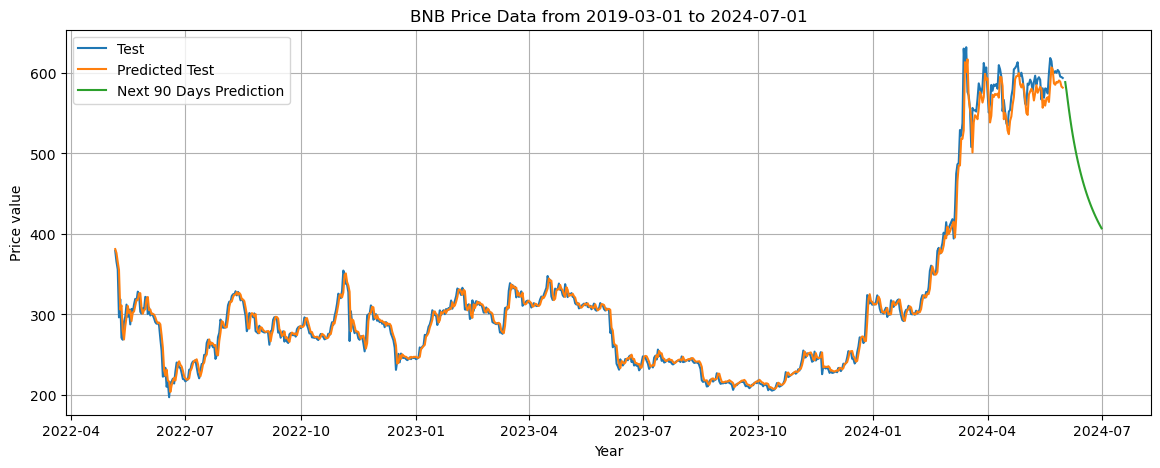

In [3]:
# The process of creating index to predict the next 90 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 90 days
lst_output = []
n_steps = time_step
i = 0
while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_30_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 90 days
print('Predicted XRP prices for the next 30 days:')
print(y_next_30_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 90 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_30_days, y_next_30_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"BNB Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predicted Price for next 60 days


Predicted BNB prices for the next 60 days:
[588.70818055 577.89664085 565.70026278 553.82924239 542.70586844
 532.38912695 522.82874258 513.94659769 505.66898961 497.93156276
 490.68348497 483.87662876 477.47129891 471.4320561  465.72763735
 460.33047873 455.21635742 450.36307909 445.75135297 441.36359861
 437.18394588 433.1981554  429.3932606  425.75752792 422.28021817
 418.95158653 415.76256436 412.70491826 409.77113082 406.95396302
 404.24721    401.64470666 399.14108342 396.73109    394.40995342
 392.17329847 390.01682947 387.93672803 385.92941444 383.99134873
 382.11946824 380.31078988 378.56237029 376.87162414 375.23604559
 373.65324818 372.1211636  370.63748492 369.20042228 367.80798694
 366.45842881 365.1499978  363.88122223 362.65051113 361.45643259
 360.29767406 359.17280363 358.0807474  357.02011323 355.989867  ]


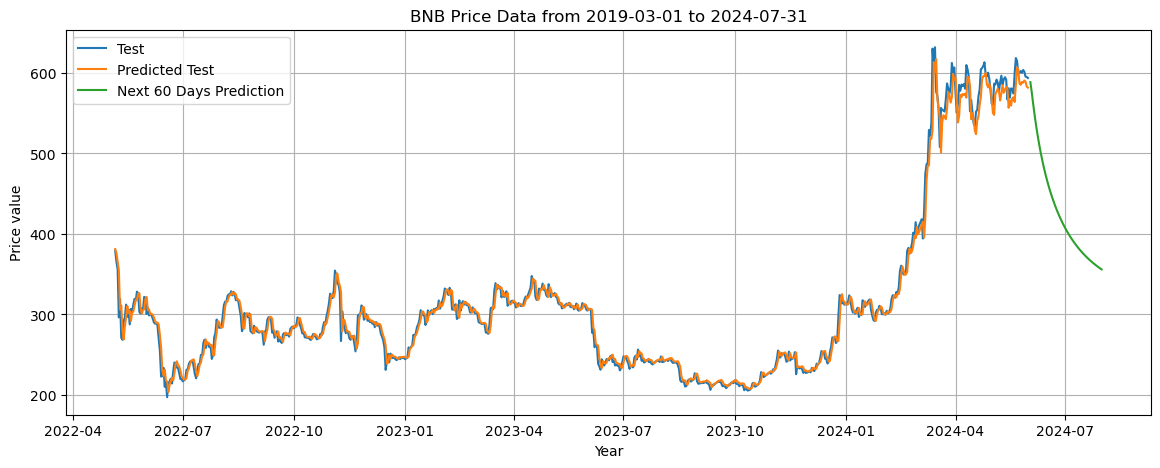

In [4]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 60):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_60_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted BNB prices for the next 60 days:')
print(y_next_60_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_60_days, y_next_60_days, label='Next 60 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"BNB Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predict Price for the next 90 days </h2>

Predicted BNB prices for the next 90 days:
[588.70818055 577.89664085 565.70026278 553.82924239 542.70586844
 532.38912695 522.82874258 513.94659769 505.66898961 497.93156276
 490.68348497 483.87662876 477.47129891 471.4320561  465.72763735
 460.33047873 455.21635742 450.36307909 445.75135297 441.36359861
 437.18394588 433.1981554  429.3932606  425.75752792 422.28021817
 418.95158653 415.76256436 412.70491826 409.77113082 406.95396302
 404.24721    401.64470666 399.14108342 396.73109    394.40995342
 392.17329847 390.01682947 387.93672803 385.92941444 383.99134873
 382.11946824 380.31078988 378.56237029 376.87162414 375.23604559
 373.65324818 372.1211636  370.63748492 369.20042228 367.80798694
 366.45842881 365.1499978  363.88122223 362.65051113 361.45643259
 360.29767406 359.17280363 358.0807474  357.02011323 355.989867
 354.98901432 354.01644151 353.0711542  352.15223756 351.25881655
 350.39001613 349.54508057 348.72305529 347.92338343 347.14526949
 346.38795777 345.6508914  344.9332

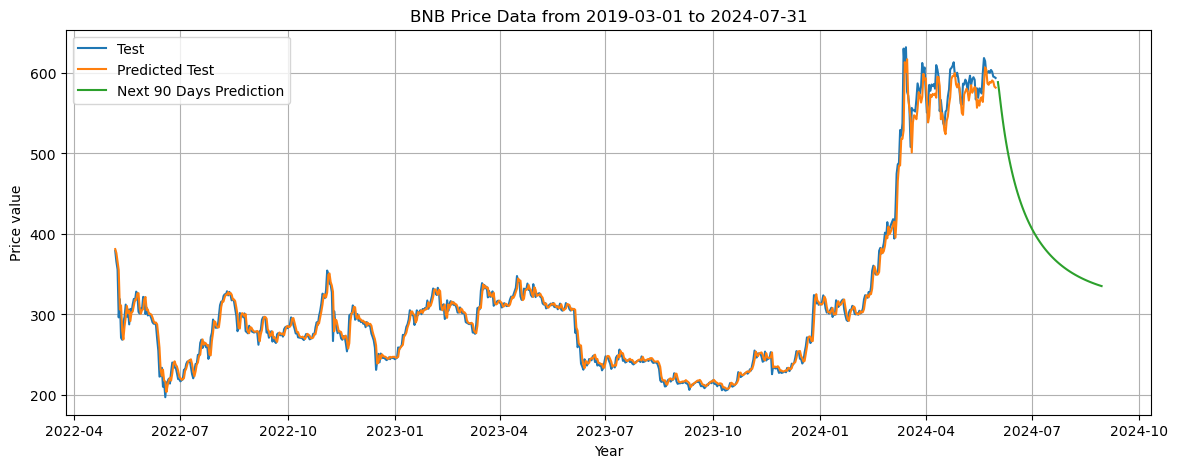

In [5]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 90):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_90_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted BNB prices for the next 90 days:')
print(y_next_90_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_90_days, y_next_90_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"BNB Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()